In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [79]:
df = pd.read_csv('/home/rushmash/Desktop/HIV/CSVs/toi_articles.csv')
df.head(10)

,name,date,location,category,body
0,Chandigarh: NSS camp begins at KBDAV,2018-12-26,CHANDIGARH,"News,City News,Chandigarh News",CHANDIGARH: The 16th NSS week-long camp took o...
1,Number of HIV cases increasing among young: Ex...,2018-12-01,NAGPUR,"News,City News,Nagpur News",NAGPUR: While incidence of HIV has reduced all...
2,Tamarind seeds has antiviral properties and ca...,2018-11-14,NEW DELHI,"News,India News",NEW DELHI: Tamarind seeds has antiviral proper...
3,Tamarind seeds has antiviral properties and ca...,2018-11-14,NEW DELHI,"News,Education",NEW DELHI: Tamarind seeds has antiviral proper...
4,Children’s home guard not guilty of sodomising...,2018-11-15,NEW DELHI,"News,City News,Delhi News,Crime",NEW DELHI: Terming it a “classic” and “unsolve...
5,Activists irked by RCEP talks over pharma patents,2018-11-15,MUMBAI,"News,BUSINESS NEWS,India Business News",MUMBAI: Public health activists and patient gr...
6,Zika scare: MP violates blood donation norms,2018-11-16,BHOPAL,"News,City News,Bhopal News,Civic Issues",BHOPAL: Confusion prevails over guidelines fra...
7,Zydus Cadila gets USFDA nod to market generic ...,2018-11-16,"New Delhi, Nov 16 () Drug firm Zydus Cadila Fr...","News,BUSINESS NEWS,India Business News","New Delhi, Nov 16 () Drug firm Zydus Cadila Fr..."
8,Awareness programme for adolescents,2018-11-17,CHANDIGARH,"News,City News,Chandigarh News,Civic Issues","CHANDIGARH: In a bid to educate students, the ..."
9,'HIV is a sin that needs to be tackled by God'...,2018-11-19,AIZAWL,"News,City News,Guwahati News",AIZAWL: Mizoram has the highest prevalence of ...


In [80]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['body'])
print(vectorizer.get_feature_names())

['00', '000', '000km', '01', '012', '02', '021', '022', '029', '03', '034', '037', '04', '041', '04325', '05', '052', '056', '057', '058', '059', '06', '061', '07', '071', '079', '08', '081', '09', '091', '10', '100', '1000', '1006', '100c', '100km', '1012', '102', '105', '106', '107', '108', '109', '1097', '1097housing', '1098', '10am', '10ft', '10km', '10pm', '10th', '11', '110', '112', '113', '115', '116', '11682', '118', '119', '11am', '11pm', '11th', '11units', '12', '120', '1200', '1209', '120b', '121', '122', '124', '125', '126', '127', '12737', '129', '12ft', '12pm', '12th', '13', '130', '132', '134', '135', '136', '137', '14', '140', '141', '1424', '145', '146', '149', '14th', '15', '150', '1500', '1508', '151', '1512056696000', '1517884751000', '1517884752000', '1517884879000', '1517896102000', '152', '153', '1536221906000', '1536228779000', '1536243288000', '154', '155', '157', '159', '15km', '15th', '16', '160', '163', '1641', '166', '168', '169', '16gb', '16th', '17', '170

In [81]:
# normalization
tf_idf = normalize(x)

In [82]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
#     if seed is not None: # useful for obtaining consistent results
#         np.random.seed(seed)
    n = data.shape[0]
    rand_indices = np.random.randint(0, n, k)
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [83]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignment = np.argmin(distances_from_centroids, axis=1) 
    return cluster_assignment

In [84]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        member_data_points = data[cluster_assignment==i]
        centroid = member_data_points.mean(axis=0)
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    return new_centroids

In [85]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [86]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
            
        cluster_assignment = assign_clusters(data, centroids)
            
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment-cluster_assignment))
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [87]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1


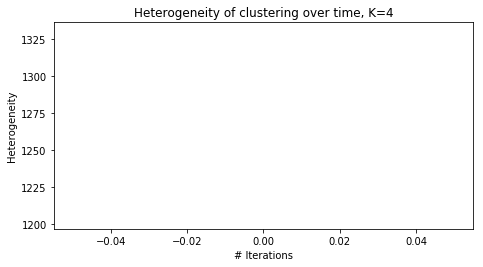

In [88]:
k = 4
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [89]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [90]:
heterogeneity

[1266.6857651306664]